In [1]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io 
from sklearn import svm 
import re 
from stemming.porter2 import stem
import nltk, nltk.stem.porter
from collections import Counter

In [47]:
cd C:\Users\诚明\Desktop\MachineLearning\spam_classify\

C:\Users\诚明\Desktop\MachineLearning\spam_classify


# 1. Read in spam and non-spam emails

In [60]:
# read in the non-spam emails into a long list
current_dir = os.getcwd()
nonspam_emails = []
for file in os.listdir(current_dir + '\\easy_ham\\'):
    temp = open(current_dir + '\\easy_ham\\' + file, 'rb').read()
    nonspam_emails.append(temp)

# read in spam emails into a long list
spam_emails = []
for file in os.listdir(current_dir + '\\spam\\'):
    temp = open(current_dir + '\\spam\\' + file, 'rb').read()
    spam_emails.append(temp)

## 1.1. Encoding

In [61]:
# Note that the encoding is bytes. So we need to transform it into latin-1
for i in range(len(nonspam_emails)):
    try:
        nonspam_emails[i] = str(nonspam_emails[i], encoding = 'utf-8')
    except:
        nonspam_emails[i] = str(nonspam_emails[i], encoding = 'latin-1')

In [62]:
for i in range(len(spam_emails)):
    try:
        spam_emails[i] = str(spam_emails[i], encoding = 'utf-8')
    except:
        spam_emails[i] = str(spam_emails[i], encoding = 'latin-1')

In [5]:
print(nonspam_emails[1])

From Steve_Burt@cursor-system.com  Thu Aug 22 12:46:39 2002
Return-Path: <Steve_Burt@cursor-system.com>
Delivered-To: zzzz@localhost.netnoteinc.com
Received: from localhost (localhost [127.0.0.1])
	by phobos.labs.netnoteinc.com (Postfix) with ESMTP id BE12E43C34
	for <zzzz@localhost>; Thu, 22 Aug 2002 07:46:38 -0400 (EDT)
Received: from phobos [127.0.0.1]
	by localhost with IMAP (fetchmail-5.9.0)
	for zzzz@localhost (single-drop); Thu, 22 Aug 2002 12:46:38 +0100 (IST)
Received: from n20.grp.scd.yahoo.com (n20.grp.scd.yahoo.com
    [66.218.66.76]) by dogma.slashnull.org (8.11.6/8.11.6) with SMTP id
    g7MBkTZ05087 for <zzzz@spamassassin.taint.org>; Thu, 22 Aug 2002 12:46:29 +0100
X-Egroups-Return: sentto-2242572-52726-1030016790-zzzz=spamassassin.taint.org@returns.groups.yahoo.com
Received: from [66.218.67.196] by n20.grp.scd.yahoo.com with NNFMP;
    22 Aug 2002 11:46:30 -0000
X-Sender: steve.burt@cursor-system.com
X-Apparently-To: zzzzteana@yahoogroups.com
Received: (EGP: mail-8_1_0_

## 1.2. Remove the header

In [63]:
# It seems that there will be a double new line in the header of every email. Check whether this is right.
count = 0
for nonspam in nonspam_emails:
    count += 1
    if '\n\n' not in nonspam:
        print('No.%s nonspam email does not have a double new line!' % count)
        print(nonspam[:500])

count = 0
for spam in spam_emails:
    count += 1
    if '\n\n' not in spam:
        print('\nNo.%s spam email does not have a double new line!' % count)
        print(spam[:500])

No.2501 nonspam email does not have a double new line!
mv 00001.7c53336b37003a9286aba55d2945844c 00001.7c53336b37003a9286aba55d2945844c
mv 00002.9c4069e25e1ef370c078db7ee85ff9ac 00002.9c4069e25e1ef370c078db7ee85ff9ac
mv 00003.860e3c3cee1b42ead714c5c874fe25f7 00003.860e3c3cee1b42ead714c5c874fe25f7
mv 00004.864220c5b6930b209cc287c361c99af1 00004.864220c5b6930b209cc287c361c99af1
mv 00005.bf27cdeaf0b8c4647ecd61b1d09da613 00005.bf27cdeaf0b8c4647ecd61b1d09da613
mv 00006.253ea2f9a9cc36fa0b1129b04b806608 00006.253ea2f9a9cc36fa0b1129b04b806608
mv 00007.37a8a

No.501 spam email does not have a double new line!
mv 00001.7848dde101aa985090474a91ec93fcf0 00001.7848dde101aa985090474a91ec93fcf0
mv 00002.d94f1b97e48ed3b553b3508d116e6a09 00002.d94f1b97e48ed3b553b3508d116e6a09
mv 00003.2ee33bc6eacdb11f38d052c44819ba6c 00003.2ee33bc6eacdb11f38d052c44819ba6c
mv 00004.eac8de8d759b7e74154f142194282724 00004.eac8de8d759b7e74154f142194282724
mv 00005.57696a39d7d84318ce497886896bf90d 00005.57696a39d7d84318ce49

In [64]:
# This seems to be the case that the last file of spam and nonspam email is not an email at all. So we remove them.
nonspam_emails = nonspam_emails[:-1]
spam_emails = spam_emails[:-1]

In [65]:
# Now we can erase the header.
nonspam_emails = [nonspam.split(sep = '\n\n',maxsplit = 1)[1] for nonspam in nonspam_emails]
spam_emails = [spam.split(sep = '\n\n',maxsplit = 1)[1] for spam in spam_emails]

# 2. Preprocess the e-mails to turn them into a format an SVM can understand

In [66]:
def preProcess(email):
    email = email.lower()
    email = re.sub('\d+','number',email)        # Replace all numbers with a single string "number" to treat all numbers equally.
    email = re.sub('(http|https)://[\S]*','httpaddr',email)
    email = re.sub('<[^<>]*>',' ',email)        # Remove html tags like <blah>
    email = re.sub('[$]+','dollar',email)
    email = re.sub('\S+@\S+','emailaddr',email)
    return email

## 2.1. Tokenization

In [67]:
# Break each email up into 'words' which can be defined as strings separated by a space, or separated by some other delimiters that I use.
# Each token (or word) is then stemmed, which means I attempt to shorten each word to its root.

def email2tokenlist(raw_email):
    email = preProcess(raw_email)
    stemmer = nltk.stem.porter.PorterStemmer()
    tokens = re.split('\W',email)
    tokenlist = []
    for token in tokens:
        token = re.sub('[^a-zA-Z0-9]','',token)
        try:
            stemmed = stemmer.stem(token)
        except:
            continue
        if not len(token):
            continue
        tokenlist.append(token)
    return tokenlist

## 2.2. Create a vocabulary dictionary

In [68]:
# Find 1000 most common words for both spam and non-spam emails 
full_nonspam = [' '.join(nonspam_emails[:])]
full_spam = [' '.join(spam_emails[:])]
full_emails = full_nonspam[0] + full_spam[0]

In [69]:
counts = Counter(email2tokenlist(full_emails))
Common_words = counts.most_common(1000)

In [70]:
vocab_dict = dict(zip([word[0] for word in Common_words], list(range(len(Common_words)))))

## 2.3. Create features

In [71]:
def email2Vocabind(raw_email, vocab_dict):
    tokenlist = email2tokenlist(raw_email)
    vocab_ind = [vocab_dict[token] for token in tokenlist if token in vocab_dict]
    return vocab_ind

In [72]:
def email2featurevec(raw_email, vocab_dict):
    vocab_ind = email2Vocabind(raw_email, vocab_dict)
    feature = np.zeros((len(vocab_dict), 1))
    feature[vocab_ind] = 1
    return feature

# 3. Trarning SVM for spam classification

## 3.1. Build training set, validation set and test set

In [74]:
n_spam = len(spam_emails)
n_nonspam = len(nonspam_emails)

spam_train = [email2featurevec(email, vocab_dict) for email in spam_emails[:int(n_spam*0.6)]]
nonspam_train = [email2featurevec(email, vocab_dict) for email in nonspam_emails[:int(n_nonspam*0.6)]]
X_train = np.concatenate((spam_train, nonspam_train))[:,:,0]
y_train = np.concatenate((np.ones((int(n_spam*0.6), 1)), np.zeros((int(n_nonspam*0.6), 1))))

spam_cv = [email2featurevec(email, vocab_dict) for email in spam_emails[int(n_spam*0.6):int(n_spam*0.8)]]
nonspam_cv = [email2featurevec(email, vocab_dict) for email in nonspam_emails[int(n_nonspam*0.6):int(n_nonspam*0.8)]]
X_cv = np.concatenate((spam_cv, nonspam_cv))[:,:,0]
y_cv = np.concatenate((np.ones((int(n_spam*0.8) - int(n_spam*0.6), 1)), np.zeros((int(n_nonspam*0.8) - int(n_nonspam*0.6), 1))))

spam_test = [email2featurevec(email, vocab_dict) for email in spam_emails[int(n_spam*0.8):]]
nonspam_test = [email2featurevec(email, vocab_dict) for email in nonspam_emails[int(n_nonspam*0.8):]]
X_test = np.concatenate((spam_test, nonspam_test))[:,:,0]
y_test = np.concatenate((np.ones((n_spam - int(n_spam*0.8), 1)), np.zeros((n_nonspam - int(n_nonspam*0.8), 1))))

## 3.2. Choose a C value based on validation set performance

In [75]:
C_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0]
train_score, cv_score = [], []
for i in range(len(C_range)):
    fit = svm.SVC(C=C_range[i], kernel = 'linear').fit(X_train, y_train.flatten())
    train_score.append(fit.score(X_train, y_train.flatten()))
    cv_score.append(fit.score(X_cv, y_cv.flatten()))
    print('C = %s   Training set error is %.4f   CV set error is %.4f' % (C_range[i], train_score[i], cv_score[i]))

C = 0.0001   Training set error is 0.8333   CV set error is 0.8333
C = 0.001   Training set error is 0.9039   CV set error is 0.9067
C = 0.01   Training set error is 0.9917   CV set error is 0.9683
C = 0.1   Training set error is 0.9994   CV set error is 0.9767
C = 1.0   Training set error is 0.9994   CV set error is 0.9683
C = 10.0   Training set error is 1.0000   CV set error is 0.9500


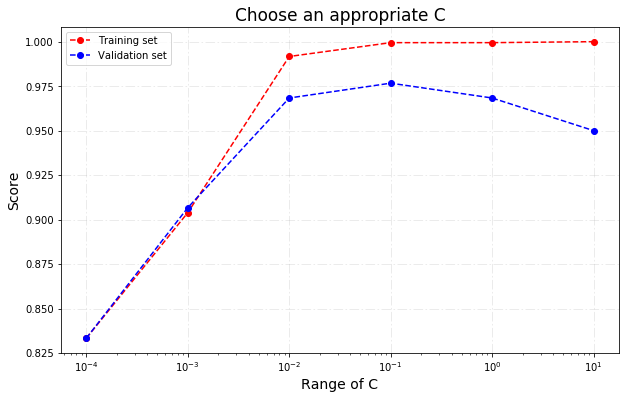

In [76]:
plt.figure(figsize = (10,6))
plt.plot(C_range, train_score, 'ro--', label = 'Training set')
plt.plot(C_range, cv_score, 'bo--', label = 'Validation set')
plt.xscale('log')
plt.xlabel('Range of C', fontsize = 14)
plt.ylabel('Score', fontsize = 14)
plt.title('Choose an appropriate C', fontsize = 17)
plt.grid('both', linestyle = '-.', alpha=0.3)
plt.legend()

## 3.3. Test the model

In [77]:
# So we choose C = 0.1
fit = svm.SVC(C=0.1, kernel = 'linear').fit(X_train, y_train.flatten())
test_score = fit.score(X_test, y_test.flatten())
print('Test score is %.3f' % test_score)

Test score is 0.992


In [78]:
with open('Reminder_ HKUST MSc Program - Application of Off-Campus Housing (starts at 10am on Apr 20).txt','rb') as f:
    email1 = str(f.read(), encoding = 'utf-8')

with open('Complete Unsupervised Learning.txt','rb') as f:
    email2 = str(f.read(), encoding = 'utf-8')

X1 = email2featurevec(email1, vocab_dict)
X2 = email2featurevec(email2, vocab_dict)
int(fit.predict(X1.T)), int(fit.predict(X2.T))

(1, 1)